# Explore UniProt keywords

url: https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=%28taxonomy_id%3A9606%29
1. Select the following columns:
Entry	Entry Name	Protein Names	Gene Names	Organism	Keywords HGNC

2. Select Reviewed only (~20,500)

In [2]:
from collections import Counter

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import os.path as osp
import json

Below, I downloaded the [UniProt table for human proteins](https://www.uniprot.org/uniprotkb?query=%28Human%29). I added on Keywords and HGNC as columns:

In [3]:
MAPPING_DIR = '../data/mappings/'

In [4]:
# Release 2022_05
uniprot = pd.read_csv(
    osp.join(MAPPING_DIR, 'uniprotkb_human_2023_08_30.tsv.gz'),
    sep='\t',
    compression='gzip',
    usecols=[
        'Keywords',
        'Entry',
    ]
)

In [5]:
uniprot.head(10)

,Entry,Keywords
0,A0A023HI18,Apoptosis;Clathrin-mediated endocytosis of vir...
1,A0A023HIB6,Acetylation;Activator;Apoptosis;Host cytoplasm...
2,A0A023HIP6,Apoptosis;Clathrin-mediated endocytosis of vir...
3,A0A023HIT0,Apoptosis;Early protein;Host cell membrane;Hos...
4,A0A023HIT3,Acetylation;Activator;Apoptosis;Host cytoplasm...
5,A0A023J4Z7,3D-structure;Disulfide bond;Fusion of virus me...
6,A0A023J501,Disulfide bond;Fusion of virus membrane with h...
7,A0A023J521,Activation of host autophagy by virus;ATP-bind...
8,A0A023J560,Disulfide bond;Fusion of virus membrane with h...
9,A0A023J5A2,Disulfide bond;Fusion of virus membrane with h...


Get our KG and all the protein nodes inside. We are getting the KG which includes the test set:

In [6]:
KG_DIR = '../data/kg'

In [7]:
kg = pd.read_csv(osp.join(KG_DIR, 'full_final_kg.tsv'), sep='\t')

Get the proteins:

In [8]:
target_sets = set(kg[kg['target'].str.startswith('ncbigene')]['target'].tolist())
source_sets = set(kg[kg['source'].str.startswith('ncbigene')]['source'].tolist())
proteins_in_kg = target_sets.union(source_sets)
len(proteins_in_kg)

4037

Next, let's get a mapping from UniProt to NCBI gene ID:

In [9]:
with open(osp.join(MAPPING_DIR, 'uniprot2ncbi.json')) as f:
    uniprot2ncbi = json.load(f)

Get the valid protein classes:

In [10]:
valid_keywords = pd.read_csv(
    osp.join(MAPPING_DIR, 'molecular_function.tsv'),
    sep='\t',
)

In [11]:
valid_keywords

,Keyword ID,Name,Category,Gene Ontologies
0,KW-0008,Acetylcholine receptor inhibiting toxin,Molecular function,GO:0030550:acetylcholine receptor inhibitor ac...
1,KW-0009,Actin-binding,Molecular function,GO:0003779:actin binding
2,KW-0010,Activator,Molecular function,NaN
3,KW-0012,Acyltransferase,Molecular function,GO:0016746:acyltransferase activity
4,KW-0021,Allosteric enzyme,Molecular function,"GO:0003824:catalytic activity, GO:0008152:meta..."
...,...,...,...,...
193,KW-1244,Viral short tail ejection system,Molecular function,GO:0099002:viral genome ejection through host ...
194,KW-1255,Viral exotoxin,Molecular function,NaN
195,KW-1265,Chloride channel impairing toxin,Molecular function,NaN
196,KW-1275,Proton-gated sodium channel impairing toxin,Molecular function,NaN


In [12]:
molecular_functions = valid_keywords.Name.unique()

Now, we'll make a dictionary mapping each of our KG proteins to their protein class (or keywords):

In [13]:
all_keywords = []

not_mapped = 0
no_keywords = 0

protein_to_keywords = {}

for prot_name, keywords in tqdm(uniprot.values):
    # Map from UniProt to NCBI
    if 'UniProt:' + str(prot_name) not in uniprot2ncbi:
        not_mapped += 1
        continue
    
    """Get keywords"""
    protein_keywords = set()
    
    for keyword in keywords.split(';'):
        
        if keyword not in molecular_functions:
            continue
        
        protein_keywords.add(keyword.strip())
        all_keywords.append(keyword.strip())
        
    if not protein_keywords:
        no_keywords += 1
        continue
        
    protein_to_keywords[uniprot2ncbi['UniProt:' + str(prot_name)]] = protein_keywords

100%|██████████| 6736891/6736891 [00:04<00:00, 1438719.94it/s]


In [14]:
len(protein_to_keywords), no_keywords, not_mapped, len(set(all_keywords))

(11215, 8886, 6716790, 130)

Which keywords are most common? 

In [15]:
valid_keywords = [
    k
    for k, c in Counter(all_keywords).items()
    if c > 50
]

In [16]:
len(valid_keywords)

61

Removing superclasses and keywords with a few proteins

In [17]:
protein_to_keywords = {
    protein: {
        keyword
        for keyword in keywords
        if keyword in valid_keywords and keyword not in [
            'Transducer',
            'Serine/threonine-protein kinase',
            'Activator',
        ]
    }
    for protein, keywords in protein_to_keywords.items()
}

In [22]:
kg_nodes_with_keywords = 0
kg_nodes_without = 0
number_of_keywords = {}

keywords_in_nodes = []

for node in proteins_in_kg:
    
    if node not in protein_to_keywords:
        kg_nodes_without += 1
    else:
        kg_nodes_with_keywords += 1
        number_of_keywords[node] = len(protein_to_keywords[node])
        
        # For the ones with multiple keywords, see what they are
        if len(protein_to_keywords[node]) > 1:
            for keyword in protein_to_keywords[node]:
                keywords_in_nodes.append(keyword)

kg_nodes_with_keywords, kg_nodes_without

(2932, 1105)

In [23]:
Counter(keywords_in_nodes).most_common()

[('Receptor', 417),
 ('Transferase', 388),
 ('DNA-binding', 293),
 ('Hydrolase', 292),
 ('Kinase', 269),
 ('G-protein coupled receptor', 246),
 ('Developmental protein', 200),
 ('Repressor', 166),
 ('RNA-binding', 128),
 ('Ion channel', 113),
 ('Protease', 96),
 ('Chromatin regulator', 80),
 ('Ribonucleoprotein', 79),
 ('Tyrosine-protein kinase', 64),
 ('Oxidoreductase', 63),
 ('Voltage-gated channel', 55),
 ('Growth factor', 55),
 ('Helicase', 51),
 ('Protein phosphatase', 50),
 ('Calmodulin-binding', 41),
 ('Cytokine', 38),
 ('Ribosomal protein', 38),
 ('Ligand-gated ion channel', 37),
 ('Heparin-binding', 34),
 ('Serine protease', 33),
 ('Nuclease', 32),
 ('Calcium channel', 31),
 ('Metalloprotease', 30),
 ('Host cell receptor for virus entry', 30),
 ('Methyltransferase', 29),
 ('Monooxygenase', 29),
 ('Acyltransferase', 26),
 ('Protease inhibitor', 25),
 ('Thiol protease', 24),
 ('Allosteric enzyme', 24),
 ('Glycosyltransferase', 21),
 ('Chaperone', 21),
 ('Serine protease inhibito

Text(-3.6805555555555554, 0.5, 'Number of nodes')

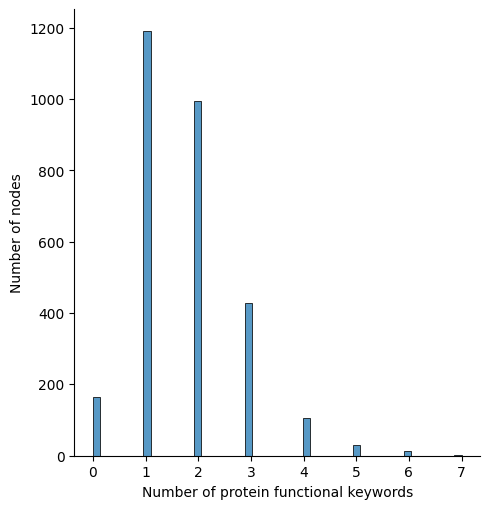

In [24]:
sns.displot(list(number_of_keywords.values()))
# add x axis label
plt.xlabel("Number of protein functional keywords")
# add y axis label
plt.ylabel("Number of nodes")